# **Random Forest**

I've decided to use as initial model the Random Forest because:
- it exploit bagging to improve accuracy of the Decision Trees
- each node is built on a small subset of the feature set, forcing the algortihm to use different features for each model (improving independency between them)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

#### DATA PREPARATION

train_features = df_train.columns.tolist()
test_features = df_test.columns.tolist()
features_toremove =  list(set(train_features) - set(test_features) - {'sii'})

del df_train['id']
for col in features_toremove:
    del df_train[col]
df_train.dropna(subset=['sii'], inplace=True)

physical_measures_df = pd.read_csv('data/physical_measures.csv')

df_train = df_train.merge( physical_measures_df, on=['Basic_Demos-Age', 'Basic_Demos-Sex'], suffixes=('', '_avg'))
cols = ['Physical-BMI','Physical-Height','Physical-Weight','Physical-Waist_Circumference','Physical-Diastolic_BP','Physical-HeartRate','Physical-Systolic_BP']
tot_nan_phys = df_train[cols].isna().all(axis=1)

for col in cols:
    df_train.loc[tot_nan_phys, col] = df_train.loc[tot_nan_phys, f"{col}_avg"]
    del df_train[f"{col}_avg"]


X = df_train.iloc[:, :-1]
y = df_train.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

is_numerical = np.array([np.issubdtype(dtype, np.number) for dtype in X.dtypes])  
numerical_idx = np.flatnonzero(is_numerical) 
new_X_train = X_train.iloc[:, numerical_idx]
new_X_test = X_test.iloc[:, numerical_idx]


scaler = StandardScaler()
imputer = KNNImputer(n_neighbors=3)

scaled_train = scaler.fit_transform(new_X_train)
X_array = imputer.fit_transform(scaled_train)
X_array = scaler.inverse_transform(X_array)
new_X_train = pd.DataFrame(X_array, columns=new_X_train.columns, index=new_X_train.index) # convert into a dataframe since X_array is of type ndarray

scaled_test = scaler.fit_transform(new_X_test)
X_array = imputer.fit_transform(scaled_test)
X_array = scaler.inverse_transform(X_array)
new_X_test = pd.DataFrame(X_array, columns=new_X_test.columns, index=new_X_test.index)

categorical_idx = np.flatnonzero(is_numerical==False)
categorical_X_train = X_train.iloc[:, categorical_idx]
categorical_X_test = X_test.iloc[:, categorical_idx]

imputer = SimpleImputer(strategy='most_frequent')
X_array = imputer.fit_transform(categorical_X_train)
categorical_X_train = pd.DataFrame(X_array, columns=categorical_X_train.columns, index=categorical_X_train.index)

X_array = imputer.fit_transform(categorical_X_test)
categorical_X_test = pd.DataFrame(X_array, columns=categorical_X_test.columns, index=categorical_X_test.index)


oh = OneHotEncoder(sparse_output=False)

oh.fit(categorical_X_train)
encoded = oh.transform(categorical_X_train)

for i, col in enumerate(oh.get_feature_names_out()):
    new_X_train = new_X_train.copy()
    new_X_train[col] = encoded[:, i]

oh.fit(categorical_X_test)
encoded = oh.transform(categorical_X_test)

for i, col in enumerate(oh.get_feature_names_out()):
    new_X_test = new_X_test.copy()
    new_X_test[col] = encoded[:, i]

### Tuning the HyperParameter
We have the Random Forest model from the previous notebook as basic model, let's do some refinement and see if it's possible to improve our accuracy. <br>
We will start by tuning the hyperparameter of the Random Forest model.<br>
Usually the validation set is used to do this, indeed the validation set is used to simulate an unseen test set on which it's possible to tune/validate the algorithm's parameters. <br>
We are going to use a k-fold cross-validation that tune the hyperparameters automatically.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

base_model = RandomForestClassifier()
parameters = { 'n_estimators': [50, 100, 200],
    'max_leaf_nodes': [50, 80, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
    }
tuned_model = GridSearchCV(base_model, parameters, cv=5, scoring='accuracy', n_jobs=-1)
tuned_model.fit(new_X_train, y_train)
print ("Best Score: {:.3f}".format(tuned_model.best_score_) )
print("Best Params: ", tuned_model.best_params_)
test_acc = accuracy_score(y_true = y_test, y_pred = tuned_model.predict(new_X_test) )
print("Test Accuracy: {:.3f}".format(test_acc) )

Best Score: 0.613
Best Params:  {'bootstrap': False, 'max_depth': None, 'max_leaf_nodes': 80, 'min_samples_split': 2, 'n_estimators': 50}
Test Accuracy: 0.588


We got a better model that has tuned the hyperparameters using the k-fold cross validation.<br>
Let's investigate better the performance using a Confusion Matrix. This is useful to understand better the classes, specifically:
- Which are the classes that have more instances (important to understand the classes that influences more the model)
- Which are the classes that the model predict better

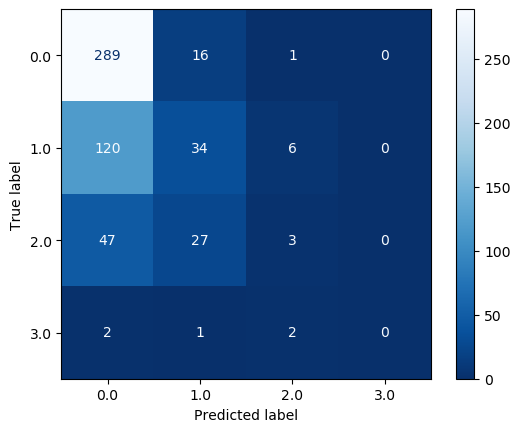

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    estimator=tuned_model.best_estimator_,
    X=new_X_test, y=y_test,
    cmap = 'Blues_r')

We can see that the classes that the model predict better are the one with more instances, this is normal since the goal of the predictor is to predict correctly more instances as possible and not to predict classes in a balanced way. <br>
Indeed class 0 has the most of the instances, so it has a larger impact on the final measure. <br>
The problem we can see is that the predictor classify a lot of instances as class 0, precisely the 84% of the instances. This number is way too high compared to the baseline accuracy that represent the percentage of instances of class 0 compared to the total (that was 56%). <br>
Since we want a model that predict the classes without being distorted by the number of instances for a specific class, let's try to give a weight inversely proportional to the frequency to balance the data.

In [8]:
base_model = RandomForestClassifier(class_weight='balanced') # give weight to the class that are inversely proportional to frequency
parameters = { 'n_estimators': [50, 100, 200],
    'max_leaf_nodes': [50, 80, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
    }
tuned_model = GridSearchCV(base_model, parameters, cv=5, scoring='accuracy', n_jobs=-1)
tuned_model.fit(new_X_train, y_train)
print ("Best Score: {:.3f}".format(tuned_model.best_score_) )
print("Best Params: ", tuned_model.best_params_)
test_acc = accuracy_score(y_true = y_test, y_pred = tuned_model.predict(new_X_test) )
print("Test Accuracy: {:.3f}".format(test_acc) )

Best Score: 0.577
Best Params:  {'bootstrap': True, 'max_depth': 20, 'max_leaf_nodes': 100, 'min_samples_split': 10, 'n_estimators': 50}
Test Accuracy: 0.573


Now we have a lower accuracy, but this is normal since, compared to last time, we are giving more importance to classes with less instances. <br>
Let's see this time how the prediction are distribuited on the possible classes:

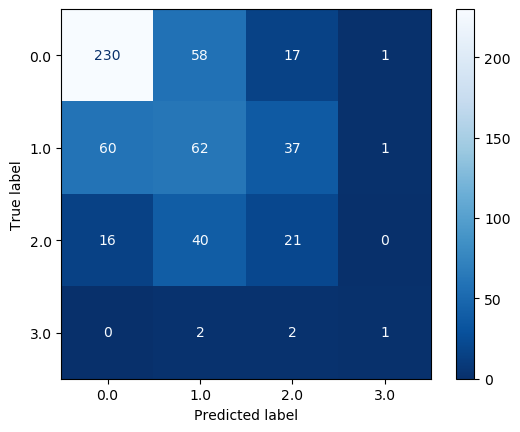

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    estimator=tuned_model.best_estimator_,
    X=new_X_test, y=y_test,
    cmap = 'Blues_r')

The prediction are now more balanced, indeed the classifier is able to also predict instances that are not from class 0.

### Feature Subset Selection
Now we have a model that uses all the features present in the dataset, to enhance efficiency and reduce overfitting, we will now select a subset of the most informative features. <br>
In this way we also reduce the risks of random collection and the generalization error of the model.

We will start by investigating the importance of the features:

['Basic_Demos-Age', 'Physical-Height', 'BIA-BIA_BMR', 'BIA-BIA_FFM', 'BIA-BIA_Fat', 'BIA-BIA_LDM', 'BIA-BIA_SMM', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T']


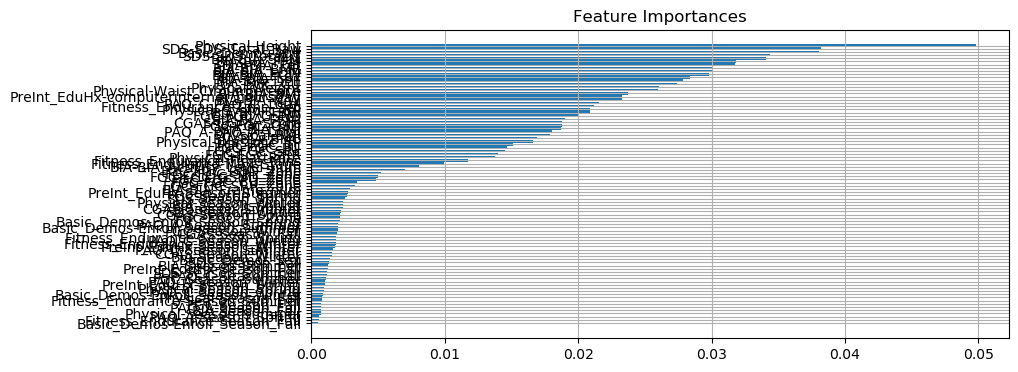

In [14]:
feature_names = new_X_train.columns.tolist()

important_features = [name for name, importance in zip(feature_names, tuned_model.best_estimator_.feature_importances_) if importance > 0.03]
print(important_features)

fig, ax = plt.subplots(figsize=(9, 4))
ax.barh(range(new_X_train.shape[1]), sorted(tuned_model.best_estimator_.feature_importances_)[::-1])
ax.set_title("Feature Importances")
ax.set_yticks(range(new_X_train.shape[1]))
ax.set_yticklabels(np.array(feature_names)[np.argsort(tuned_model.best_estimator_.feature_importances_)[::-1]])
ax.invert_yaxis() 
ax.grid()

We can see that this time the most important features are age, height and the one relative to:
- Bio-electric Impedance Analysis: measure of key body composition elements, including BMI, fat, muscle, and water content.
- Sleep Disturbance Scale:  scale to categorize sleep disorders in children <br>

For the selection of the features I will perform a Recursive Elimination in a cross-validation loop. <br>
It's a quite slow method but it's more precise than the embedded approach since it removes few features at time so it's less affected from dependencies and correlation. <br>
This time I will create the classifier with the hyperparameter tuned as it was in the last model with balanced class weight, since we have already computed the cross-validation.

In [25]:
from sklearn.feature_selection import RFECV
base_model = RandomForestClassifier(class_weight='balanced', bootstrap=True, max_depth=20, max_leaf_nodes=100, min_samples_split=10, n_estimators=50)
selector = RFECV(base_model, step=5, cv=5, scoring='accuracy', n_jobs=-1)
selector.fit(new_X_train, y_train)
X_train_subset = new_X_train.iloc[:, selector.support_]
X_test_subset = new_X_test.iloc[:, selector.support_]
print(new_X_train.shape[1])
print(X_train_subset.shape[1])
X_train_subset.columns.to_list()

# base_model = RandomForestClassifier(class_weight='balanced')
# parameters = { 'n_estimators': [50, 100, 200],
#     'max_leaf_nodes': [50, 80, 100],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5, 10],
#     'bootstrap': [True, False]
#     }
# tuned_model = GridSearchCV(base_model, parameters, cv=5, n_jobs=-1)
base_model.fit(X_train_subset, y_train)
test_acc = accuracy_score(y_true = y_test, y_pred = base_model.predict(X_test_subset) )
print("Test Accuracy: {:.3f}".format(test_acc) )

88
33
Test Accuracy: 0.584


The number of features is a lot lower, indeed now we have 33 features. We can also see that even if we have a lower number of features, the accuracy of the model is stable. <br>
The Confusion Matrix of this new model composed only by the most important features is:

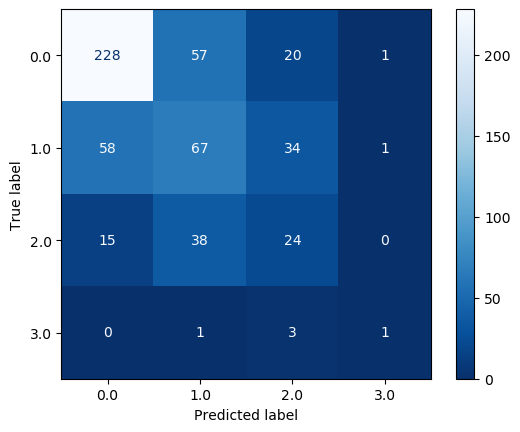

In [27]:
ConfusionMatrixDisplay.from_estimator(
    estimator=base_model,
    X=X_test_subset, y=y_test,
    cmap = 'Blues_r')

The confusion matrix is quite similiar to the one of the tuned full model, but this time we have a more robust and efficient solution since we have a lower risk of overfitting. <br>
We can also see which are the features that we have kept:

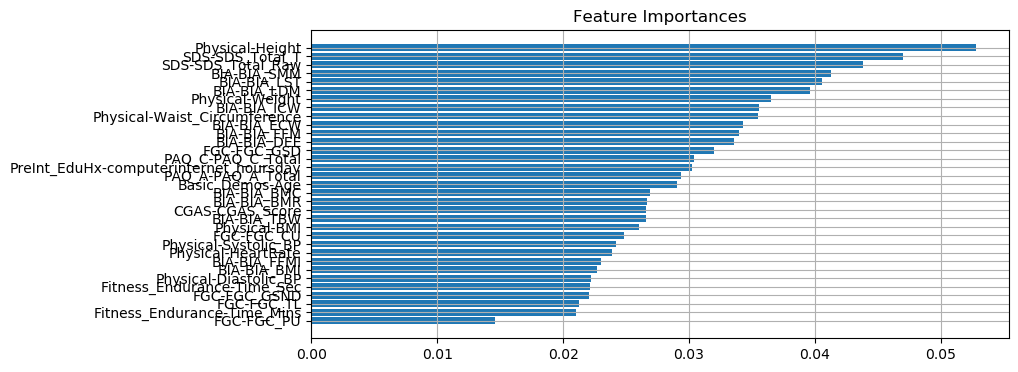

In [30]:
subset_feature_names = X_train_subset.columns.tolist()

fig, ax = plt.subplots(figsize=(9, 4))
ax.barh(range(X_train_subset.shape[1]), sorted(base_model.feature_importances_)[::-1])
ax.set_title("Feature Importances")
ax.set_yticks(range(X_train_subset.shape[1]))
ax.set_yticklabels(np.array(subset_feature_names)[np.argsort(base_model.feature_importances_)[::-1]])
ax.invert_yaxis() 
ax.grid()

The most important features are all numerical, indeed as we could immagine the categorical features wheren't that useful for the prediction since they where just informing on in what season the measurement where made. <br>
The most important features are the one related to physical measures, sleep disturbance scale and bio-electric impedance analysis, so they don't differ a lot from the most important for the full model. A difference that we can notice is that the importance of the age decreased, probabily because it was more relavant if in combination with one of the removed features.